In [26]:
'''
IMPORTS
'''
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision as tv
from scipy.ndimage import label, find_objects
import csv
from math import ceil
import cv2

In [27]:
# turns grid to image
tensorToImageTransform=tv.transforms.ToPILImage()

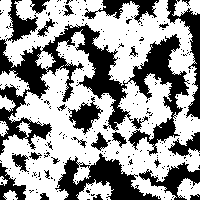

In [28]:
'''
QSGS Algorithm from Bounceback Paper
'''
def generateSampleFromPaper(rows, cols, growthProb, endingVol):
    growthMaterial=1
    vol=0
    totVol=rows*cols
    nonGrowthEndingVol=endingVol
    grid=[[(int)(not growthMaterial)]*cols for i in range(rows)]
    cores=[]
    coreProb=350*endingVol/(rows*cols)
    for row in range(rows):
        if vol/totVol>=nonGrowthEndingVol:
            break
        for col in range(cols):
            if random.random()<coreProb:
                grid[row][col]=growthMaterial
                vol+=1
                cores.append([row, col])

    dirs = [[0,1],[0,-1],[1,1],[1,-1],[1,0],[-1,1],[-1,-1],[-1,0]]
    iters=0
    prevVol=0
    
    while vol/totVol<nonGrowthEndingVol:
        idx=random.randint(0, len(cores)-1)
        [currX, currY]=cores[idx]
        adjNonGrowth=False
        for dir in dirs:
            nx, ny=currX+dir[0], currY+dir[1]
            if nx<0 or nx>=rows or ny<0 or ny>=cols:
                continue
            if grid[nx][ny]!=growthMaterial and random.random()<growthProb:
                grid[nx][ny]=growthMaterial
                cores.append([nx, ny])
                vol+=1
            if grid[nx][ny]!=growthMaterial:
                adjNonGrowth=True
        if not adjNonGrowth:
            cores[idx], cores[-1]=cores[-1], cores[idx]
            cores.pop()
        iters+=1
        if iters%(10000/growthProb)==0:
            print(iters, vol/totVol, vol, totVol, nonGrowthEndingVol, len(cores))
            if prevVol==vol:
                break
            prevVol=vol
    
    return grid

# Example usage of function
grid=generateSampleFromPaper(200, 200, 0.01, 0.6)
grid=np.array(grid, dtype=np.float32)
display(tensorToImageTransform(grid))

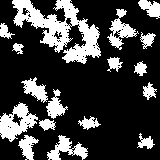

In [29]:
'''
QSGS from EG ML Paper
'''
def generateEGMLSample(rows, cols, coreProb, growthProb, wtPercent):
    growthMaterial=(int)(wtPercent>=4)
    vol=0
    totVol=rows*cols
    pDensity=914
    egDensity=269
    egPerSaturatedEG=0.1651
    nonGrowthEndingVol=(wtPercent/egDensity)/(egPerSaturatedEG*(wtPercent/egDensity+(100-wtPercent)/pDensity)) if wtPercent<4 else 1-(wtPercent/egDensity)/(egPerSaturatedEG*(wtPercent/egDensity+(100-wtPercent)/pDensity))
    grid=[[(int)(not growthMaterial)]*cols for i in range(rows)]
    cores=[]
    coreProb=min(nonGrowthEndingVol, coreProb)
    for row in range(rows):
        if vol/totVol>=nonGrowthEndingVol:
            break
        for col in range(cols):
            if random.random()<coreProb:
                grid[row][col]=growthMaterial
                vol+=1
                cores.append([row, col])

    dirs = [[0,1],[0,-1],[1,1],[1,-1],[1,0],[-1,1],[-1,-1],[-1,0]]
    iters=0
    prevVol=0
    
    while vol/totVol<nonGrowthEndingVol:
        idx=random.randint(0, len(cores)-1)
        [currX, currY]=cores[idx]
        adjNonGrowth=False
        for dir in dirs:
            nx, ny=currX+dir[0], currY+dir[1]
            if nx<0 or nx>=rows or ny<0 or ny>=cols:
                continue
            if grid[nx][ny]!=growthMaterial and random.random()<growthProb:
                grid[nx][ny]=growthMaterial
                cores.append([nx, ny])
                vol+=1
            if grid[nx][ny]!=growthMaterial:
                adjNonGrowth=True
        if not adjNonGrowth:
            cores[idx], cores[-1]=cores[-1], cores[idx]
            cores.pop()
        iters+=1
        if iters%(10000/growthProb)==0:
            print(iters, vol/totVol, vol, totVol, nonGrowthEndingVol, len(cores))
            if prevVol==vol:
                break
            prevVol=vol
    
    return grid
# Example usage
grid=generateEGMLSample(160, 160, 0.002, 0.1, 4)
grid=np.array(grid, dtype=np.float32)
display(tensorToImageTransform(grid))


[0.02084188443471519, 0.0] 0.9791581155652848


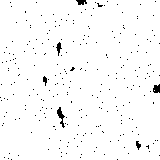

In [30]:
'''
QSGS for microCT recreation
'''
def generateMicroCTSample(rows, cols, coreProbs, growthProbs, wts, densities, absorptionRates, nonGrowthDensity):
    numMaterials=len(coreProbs)
    materials=[i/numMaterials for i in range(numMaterials)]
    grid=[[1]*cols for i in range(rows)]
    cores=[[] for i in range(numMaterials)]
    totVol=sum([wt/d for wt, d in zip(wts, densities)])+(100-sum(wts))/nonGrowthDensity
    vols=[(wt/d)/a/totVol for wt, d, a in zip(wts, densities, absorptionRates)]
    print(vols, 1-sum(vols))
    currVols=[0 for i in range(numMaterials)]
    vol=0

    for i in range(numMaterials):
        coreProb=min(vols[i], coreProbs[i])*rows*cols/(rows*cols-vol)
        for row in range(rows):
            for col in range(cols):
                if random.random()<coreProb and grid[row][col]==1:
                    grid[row][col]=materials[i]
                    vol+=1
                    totGrowth=growthProbs[i]*random.uniform(0.2, 0.8)
                    vertGrowth=totGrowth*random.uniform(0.05, 0.95)
                    horGrowth=totGrowth-vertGrowth
                    cores[i].append([row, col, vertGrowth, horGrowth])
                    currVols[i]+=1

    for i in range(numMaterials):
        for _ in range(int(rows*cols*0.01)):  # Adjust sparsity factor
            if currVols[i]/(rows*cols)>=vols[i]:
                break
            row, col=random.randint(0, rows-1), random.randint(0, cols-1)
            if grid[row][col]==1:
                grid[row][col]=materials[i]
                currVols[i]+=1

    dirs = [[0,1],[0,-1],[1,1],[1,-1],[1,0],[-1,1],[-1,-1],[-1,0]]
    iters=0
    while any([currVol/(rows*cols)<endVol for currVol, endVol in zip(currVols, vols)]):
        for i in range(numMaterials):
            if currVols[i]/(rows*cols)>=vols[i]:
                continue
            idx=random.randint(0, len(cores[i])-1)
            [currX, currY, vertGrowth, horGrowth]=cores[i][idx]
            adjNonGrowth=False
            for dir in dirs:
                nx, ny=currX+dir[0], currY+dir[1]
                if nx<0 or nx>=rows or ny<0 or ny>=cols:
                    continue
                if dir[0]==0 and grid[nx][ny]==1 and random.random()<vertGrowth:
                    grid[nx][ny]=materials[i]
                    cores[i].append([nx, ny, vertGrowth, horGrowth])
                    currVols[i]+=1
                if dir[1]==0 and grid[nx][ny]==1 and random.random()<horGrowth:
                    grid[nx][ny]=materials[i]
                    cores[i].append([nx, ny, vertGrowth, horGrowth])
                    currVols[i]+=1
                if grid[nx][ny]==1:
                    adjNonGrowth=True
            if not adjNonGrowth:
                cores[i][idx], cores[i][-1]=cores[i][-1], cores[i][idx]
                cores[i].pop()
    return grid
# Example usage of function
grid=generateMicroCTSample(rows=160, cols=160, coreProbs=[0.0005, 0.005], growthProbs=[0.1, 0.1], wts=[5, 0], densities=[2260, 2200], absorptionRates=[1, 1], nonGrowthDensity=914)
grid=np.array(grid, dtype=np.float32)
display(tensorToImageTransform(grid))

In [31]:
'''
Helper functions that calculate the widths of each worm
'''
def get_cluster_widths(grid):
    """
    Given a 2D grid (numpy array) where clusters are defined as connected regions of 0s,
    return a dictionary mapping each cluster label to its “width” (the horizontal span
    of the bounding box) and the labeled array.
    """
    # Create a boolean mask for zeros (clusters)
    zero_mask = (grid == 0)
    # Label the contiguous clusters of 0s.
    # (By default, label uses a connectivity structure that considers neighbors in all directions;
    # if you want only 4-connected neighbors, you can pass an appropriate structure.)
    structure = np.array([[0, 1, 0],
                          [1, 1, 1],
                          [0, 1, 0]], dtype=int)
    labeled_array, num_features = label(zero_mask, structure=structure)
    # Get bounding box slices for each cluster
    slices = find_objects(labeled_array)
    
    cluster_widths = {}
    for i, sl in enumerate(slices, start=1):
        if sl is None:
            continue
        # Here we define the width as the horizontal span of the bounding box.
        # That is: width = (rightmost index - leftmost index)
        width = sl[1].stop - sl[1].start
        cluster_widths[i] = width
    return cluster_widths, labeled_array

def assign_effective_k_map(grid, mapping, default_k):
    """
    Given:
      - grid: a 2D numpy array with 0s (the clusters) and 1s,
      - mapping: a dictionary where keys are tuples (min_width, max_width) and
                 the values are the effective thermal conductivities for clusters with widths in that range,
      - default_k: the default thermal conductivity to use if a cluster’s width is not in any range.
    
    Returns:
      - effective_k_map: a 2D array (same shape as grid) where every cell with a 0 in grid
                         is replaced by its effective thermal conductivity (looked up via mapping),
                         and all other cells remain at default_k (or you can later override them).
    """
    cluster_widths, labeled_array = get_cluster_widths(grid)
    # Initialize the effective conductivity map with the default (e.g. your original ks[1])
    effective_k_map = np.full(grid.shape, default_k, dtype=float)
    maxWidth=0
    # Loop over each cluster (labels are 1,2,...)
    for label_val, width in cluster_widths.items():
        maxWidth=max(maxWidth, width)
        effective_k = default_k  # if no mapping range is found, use default_k
        for (min_w, max_w), k_eff in mapping.items():
            if min_w <= width <= max_w:
                effective_k = k_eff
                break
        # Replace the conductivity for all cells in this cluster.
        effective_k_map[labeled_array == label_val] = effective_k
    return effective_k_map

def shift(array, shift_x, shift_y):
    shifted_array=np.copy(array)

    # Shift along the x-axis (rows)
    if shift_x>0:
        shifted_array[shift_x:, :]=array[:-shift_x, :]
        shifted_array[:shift_x, :]=0
    elif shift_x<0:
        shifted_array[:shift_x, :]=array[-shift_x:, :]
        shifted_array[shift_x:, :]=0

    # Shift along the y-axis (columns)
    if shift_y>0:
        shifted_array[:, shift_y:]=shifted_array[:, :-shift_y]
        shifted_array[:, :shift_y]=0
    elif shift_y<0:
        shifted_array[:, :shift_y]=shifted_array[:, -shift_y:]
        shifted_array[:, shift_y:]=0
    return shifted_array

In [32]:
'''
Function that finds average of list of conductivities
'''
def conductivityAverage(conds):
    return sum(conds)/len(conds)

# Example usage
k=conductivityAverage([24, 10, 2])
k

12.0

In [33]:
'''
Pulls Mori-Tanaka data from specified file in the 'open' function call and stores it inside gammaMapping
To get the thermal conductivity values with respect to lateral length at a specific gamma and wt% use gammaMapping[gamma][wt%] ex: gammaMapping[0.01][1]
NOTE: You can modify the resolution and threshold for flipping from FM to FF of the simulation using the resolution parameter and threshold parameter.
      If you want to do pure FM you can set threshold to be very high.
'''
gammaMapping={}
gammaMapping[0.01]={}
gammaMapping[0.0006]={}
with open(f'./data/k_gamma400.csv', mode='r') as infile:
    reader=csv.reader(infile)
    prev=0
    resolution=20e-6
    threshold=100e-6
    for i, row in enumerate(reader):
        if i==0:
            continue
        for wt, col in enumerate(range(1, 16, 3)):
            if wt+1 not in gammaMapping[0.01]:
                gammaMapping[0.01][wt+1]={}
            if wt+1 not in gammaMapping[0.0006]:
                gammaMapping[0.0006][wt+1]={}
            gammaMapping[0.01][wt+1][(prev, float(row[0])/resolution)]=float(row[col+1]) if float(row[0])>=threshold else float(row[-(wt+1)])
            gammaMapping[0.0006][wt+1][(prev, float(row[0])/resolution)]=float(row[col+2]) if float(row[0])>=threshold else float(row[-(wt+1)])
        prev=float(row[0])/resolution
gammaMapping

{0.01: {1: {(0, 0.049999999999999996): 7.27947485254301,
   (0.049999999999999996, 0.0503469315738015): 7.32790156203401,
   (0.0503469315738015, 0.05069627037794049): 7.37663421093046,
   (0.05069627037794049, 0.051048033115302496): 7.42567453114603,
   (0.051048033115302496, 0.051402236604665495): 7.47502426172899,
   (0.051402236604665495, 0.051758897781509): 7.52468514885456,
   (0.051758897781509, 0.052118033698819996): 7.5746589458164,
   (0.052118033698819996, 0.052479661527911496): 7.6249474130176,
   (0.052479661527911496, 0.05284379855923999): 7.67555231796096,
   (0.05284379855923999, 0.053210462203236): 7.7264754352385,
   (0.053210462203236, 0.0535796699911335): 7.77771854652039,
   (0.0535796699911335, 0.053951439575809): 7.82928344054322,
   (0.053951439575809, 0.054325788732626994): 7.88117191309738,
   (0.054325788732626994, 0.054702735360287): 7.93338576701394,
   (0.054702735360287, 0.055082297481682994): 7.98592681215057,
   (0.055082297481682994, 0.0554644932447609

In [ ]:
'''
Our D2Q4 LBM
Parameters:
    ks (list): List of thermal conductivities of each material in W/mK
    rhos (list): List of densities of each material in kg/m^3
    cps (list): List of specific heats of each material in J/kgK
    dt (float): Timestep to be used in LBM(larger timestep=larger relaxation times) in s
    mapping (dict): gammaMapping selection
    length (float): height of grid in m
    width (float): width of grid in m
NOTE: Default length and width is set to 1mm x 1mm. For microCT calls set length and width using parameters
'''
def lbm(grid, ks, rhos, cps, dt, mapping=gammaMapping[0.01][2], length=1e-3, width=1e-3, tolerance=3e-9, tHot=293, tCold=283):
    if type(grid) is list:
        grid=np.array(grid)
    plt.imshow(grid, cmap='hot', interpolation='nearest')
    plt.grid()
    plt.pause(0.1)

    # assigns thermal conductivites according to lateral length
    effective_k_map = assign_effective_k_map(grid, mapping, default_k=ks[1])
    kMap = np.where(grid == 1, ks[0], effective_k_map)

    plt.imshow(kMap, cmap='hot', interpolation='nearest')
    plt.grid()
    plt.colorbar()
    plt.pause(0.1)

    rows, cols=grid.shape
    tHot=293
    tCold=283
    dirs=[[1,0],[0,1],[-1,0],[0,-1]]

    # calculate thermal diffusivities in lattice units
    dx=width/cols
    diffusivity_map = np.where(grid==1, ks[0]/(rhos[0]*cps[0]), kMap/(rhos[1]*cps[1]))
    lb_diffusivity_map = diffusivity_map*dt/(dx**2)

    # initialize temperature, relaxation time, and heat capacity maps
    T=np.full((rows, cols), (tHot+tCold)/2)
    tauMap=2*lb_diffusivity_map+0.5
    heatCapMap=np.where(grid==1, rhos[0]*cps[0], rhos[1]*cps[1])
    print('relaxation times', np.max(tauMap), np.min(tauMap))
    T[:,0]=tHot
    T[:,-1]=tCold

    # initialize distribution function
    omega=1/4
    distF=np.zeros((4, rows, cols))
    distF[:,:,:]=T[:,:]*omega

    # main simulation loop
    for i in range(10000000):
        T_old=T.copy()

        T=np.sum(distF, axis=0)

        # collision
        for dir in range(4):
            distF[dir]-=(distF[dir]-T*omega)/tauMap
                
        # streaming step
        for dir, [x,y] in enumerate(dirs):
            distF[dir]=shift(distF[dir], x, y)

        # top/bottom neumann boundary conditions
        distF[0,0,:]=distF[2,0,:]
        distF[2,-1,:]=distF[0,-1,:]

        # reset left/right boundary conditions
        distF[1,:,0]=tHot-distF[0,:,0]-distF[2,:,0]-distF[3,:,0]
        distF[3,:,-1]=tCold-distF[0,:,-1]-distF[1,:,-1]-distF[2,:,-1]

        # update temp
        T=np.sum(distF, axis=0)

        # verify how much temp changed
        error=np.sqrt(np.sum(np.square((T-T_old)))/np.sum(np.square(T)))
        if i%100000==0:
            print(i, error)
        if error<tolerance:
            print("CONVERGED ON STEP", i, "WITH ERROR", error)
            break
    # Calculate thermal conductivity
    conds=[2*dx*np.sum((distF[1,:,i]-distF[3,:,i])/(T[:,i-1]-T[:,i+1])*heatCapMap[:,i]*(tauMap[:,i]-0.5)/tauMap[:,i])*(dx/dt)/rows for i in range(1, cols-1)]
    return conds, T, distF

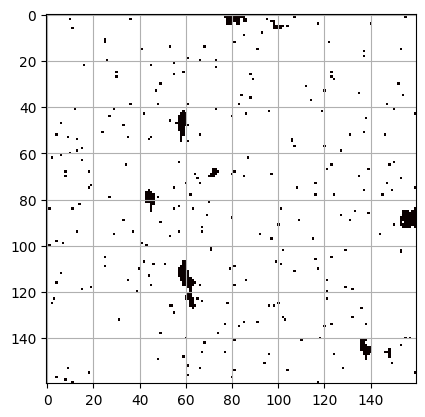

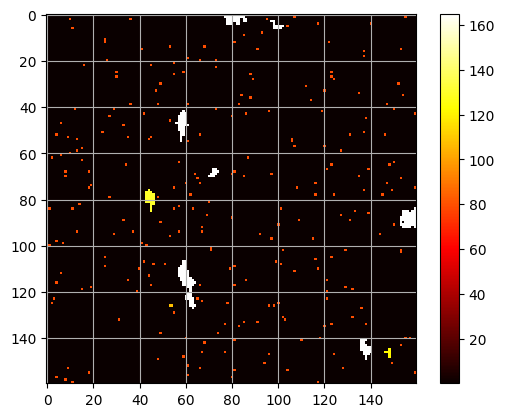

relaxation times 1.0411313096250443 0.5007983803349761
0 0.0004852568363577819
50000 5.71743284292674e-08
100000 2.976328496515969e-08
150000 2.048238573053523e-08
200000 1.5829346489126484e-08
250000 1.2998946587927313e-08
300000 1.1069312029597897e-08
350000 9.654991377022264e-09
400000 8.56645987182207e-09
450000 7.699263911959152e-09
500000 6.990670715337422e-09
550000 6.400360561210548e-09
600000 5.900974284604732e-09
650000 5.473124890429033e-09
700000 5.102584962609071e-09
750000 4.778620349681108e-09
800000 4.492950933308199e-09
850000 4.239074793272852e-09
900000 4.011814596552819e-09
950000 3.8070002071960576e-09
1000000 3.6212437843251803e-09
1050000 3.4517719606977757e-09
1100000 3.2962997612897173e-09
1150000 3.152938108957955e-09
1200000 3.020114243220454e-09
CONVERGED ON STEP 1207901 WITH ERROR 2.9999996082778667e-09
[np.float64(0.3111495489739467), np.float64(0.3115511157801693), np.float64(0.3127629479712255), np.float64(0.3133912184454771), np.float64(0.31213417556002

In [35]:
# Example usage
conds, T, distF=lbm(grid=grid, ks=[0.305, 2200], rhos=[914, 700], cps=[2140, 2229], dt=1e-7, mapping=gammaMapping[0.0006][4])
print(conds)
print(conductivityAverage(conds))

In [37]:
'''
Functions that print out conductivity plot for LBM conductivity output alongside grid.
printKPlot prints a singular graph
printKPlots prints all conductivities/grid pairs in list
printTempPlot prints temperature heatmap
printTempGradient prints temperature gradient
printGrid prints the grid
'''
def printKPlot(cond, grid):
    fig, ax=plt.subplots()
    cols=len(cond)
    plt.plot(range(cols), cond)
    plt.ylabel('k W/mK')
    plt.xlabel('x column')
    plt.title('Conductivity Graph')
    ax.imshow(grid, cmap='hot', interpolation='nearest', extent=[0, cols, np.min(cond), np.max(cond)], aspect='auto')
    ax.plot(range(cols), cond, color='cyan', linewidth=2, zorder=10)
    ax.grid(True)
    print(conductivityAverage(cond))
    plt.pause(0.1)

def printKPlots(conds, grids):
    for cond, grid in zip(conds, grids):
        printKPlot(cond, grid)

def printTempPlot(T):
    plt.imshow(T, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.pause(0.1)

def printGrid(grid):
    plt.imshow(grid, cmap='hot', interpolation='nearest')
    plt.grid()
    plt.pause(0.1)

def printTempGradient(T):
    dT=np.sqrt((((T[:,:-1]-T[:,1:])**2)[:-1,:]+((T[:-1,:]-T[1:,:])**2)[:,:-1]))
    plt.imshow(dT, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.pause(0.1)

1.1420198521017182


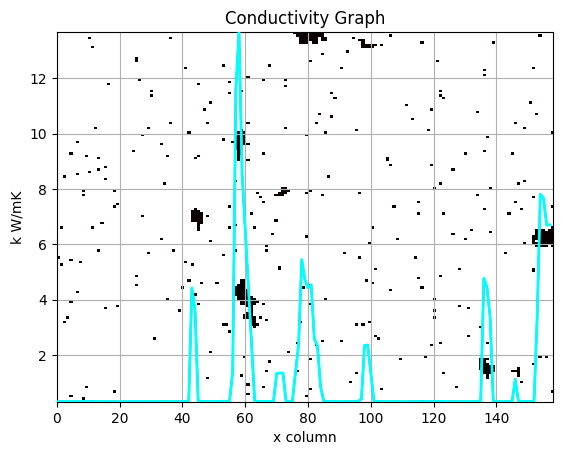

1.1420198521017182


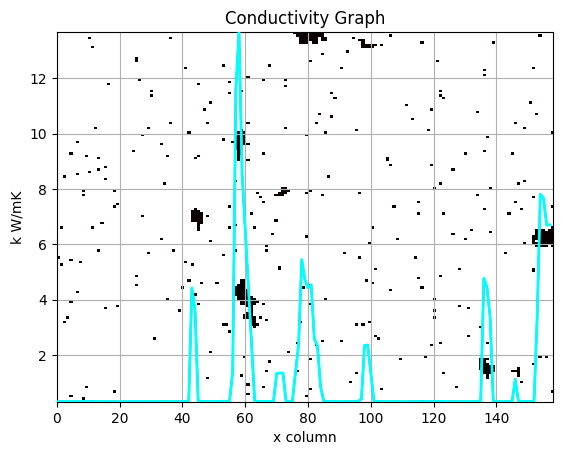

1.1420198521017182


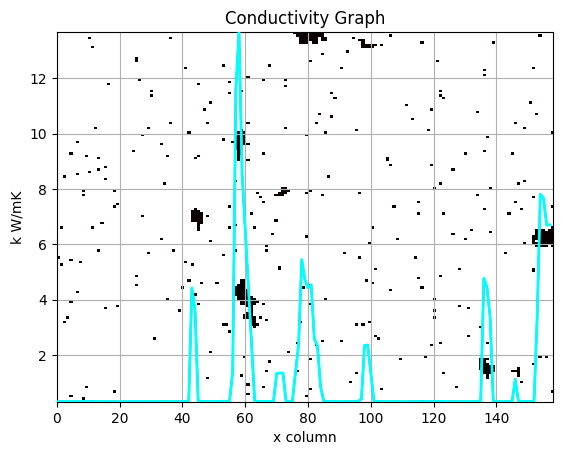

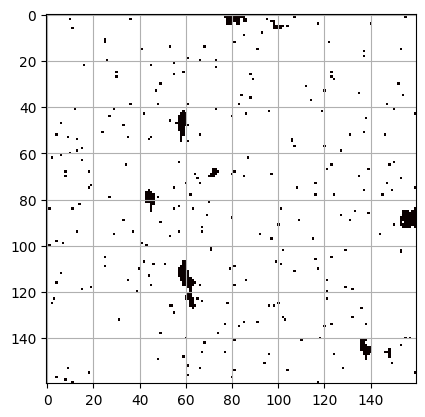

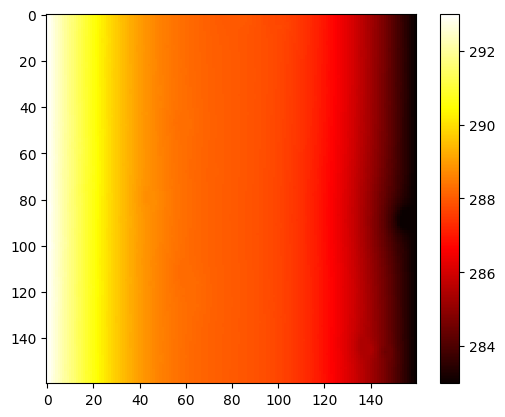

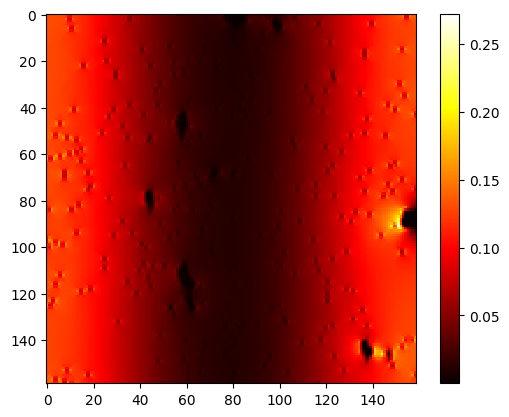

In [42]:
'''
Example usage for printing plots using functions above
'''

printKPlot(conds, grid)
printKPlots([conds, conds], [grid, grid])
printGrid(grid)
printTempPlot(T)
printTempGradient(T)

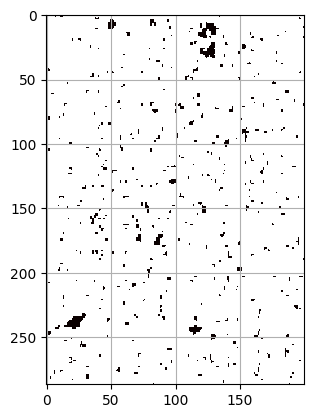

In [50]:
'''
Takes file path of image and turns it into 2d sample. Takes the top left 200x287 of the sample to ensure
LBM doesn't take too long to run
'''
def fileToSampleGrid(filePath, length, width, resolution=20e-6):
    cols=ceil(width/resolution)
    rows=ceil(length/resolution)
    image = cv2.imread(filePath)

    # Convert to RGB for displaying purposes
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert the image to HSV color space for better color segmentation
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the color range for detecting the blue box
    blue_lower = np.array([90, 50, 50])  # Lower bound of blue in HSV
    blue_upper = np.array([130, 255, 255])  # Upper bound of blue in HSV

    # Create a mask for the blue color
    blue_mask = cv2.inRange(hsv_image, blue_lower, blue_upper)

    # Find contours from the mask
    contours, _ = cv2.findContours(blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by area and assume the largest is the blue box
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    blue_box_contour = contours[0] if contours else None

    # Draw the detected contour on a copy of the original image for visualization
    contour_image = image_rgb.copy()
    if blue_box_contour is not None:
        cv2.drawContours(contour_image, [blue_box_contour], -1, (255, 0, 0), 2)

    # Check if contour was detected
    blue_box_contour is not None

    epsilon = 0.02 * cv2.arcLength(blue_box_contour, True)
    approx_corners = cv2.approxPolyDP(blue_box_contour, epsilon, True)

    # Ensure we have 4 points (a quadrilateral)
    if len(approx_corners) == 4:
        # Sort the corners to identify top-left, top-right, bottom-left, bottom-right
        approx_corners = approx_corners[:, 0, :]  # Remove unnecessary dimensions
        rect = np.zeros((4, 2), dtype="float32")

        # Sum and diff to identify corners (top-left, bottom-right, etc.)
        s = approx_corners.sum(axis=1)
        diff = np.diff(approx_corners, axis=1)

        rect[0] = approx_corners[np.argmin(s)]  # Top-left
        rect[2] = approx_corners[np.argmax(s)]  # Bottom-right
        rect[1] = approx_corners[np.argmin(diff)]  # Top-right
        rect[3] = approx_corners[np.argmax(diff)]  # Bottom-left

        # Define the destination points for perspective transform (160x160 output)
        dest = np.array([[0, 0], [cols, 0], [cols, rows], [0, rows]], dtype="float32")

        # Compute the perspective transform matrix
        M = cv2.getPerspectiveTransform(rect, dest)

        # Warp the perspective to flatten the blue box
        warped = cv2.warpPerspective(image, M, (cols, rows))

        # Convert to RGB for visualization
        warped_rgb = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
    else:
        print("Failed to detect four corners of the blue box.")

    warped_rgb=torch.tensor(warped_rgb, dtype=torch.float32)

    diff_threshold = 20      # Maximum allowed difference between channels
    brightness_threshold = 20  # Minimum brightness to consider (avoids black)

    # Calculate the difference between the max and min channel values per pixel.
    channel_diff = warped_rgb.max(dim=2).values - warped_rgb.min(dim=2).values

    # Calculate the average brightness per pixel.
    brightness = warped_rgb.mean(dim=2)

    # Create a mask: the pixel is gray if the channel difference is small and brightness is above the threshold.
    gray_mask = (channel_diff < diff_threshold) & (brightness > brightness_threshold) & (brightness < 250)

    # Set non-gray pixels to black (0,0,0)
    warped_rgb[~gray_mask, :] = 0

    # Set gray pixels to white (1,1,1) – which will appear as white when transformed back to an image.
    warped_rgb[gray_mask, :] = 1
    warped_rgb=warped_rgb[:,:,0]
    warped_rgb=warped_rgb[5:-5,5:-5]

    if warped_rgb.shape[0]>287:
        warped_rgb=warped_rgb[:287]
    if warped_rgb.shape[1]>200:
        warped_rgb=warped_rgb[:,:200]
    
    return warped_rgb

# Example usage
printGrid(fileToSampleGrid(filePath='./data/gnp4_60.png', length=7923e-6, width=5085e-6, resolution=20e-6))

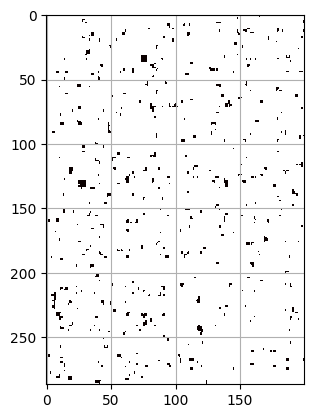

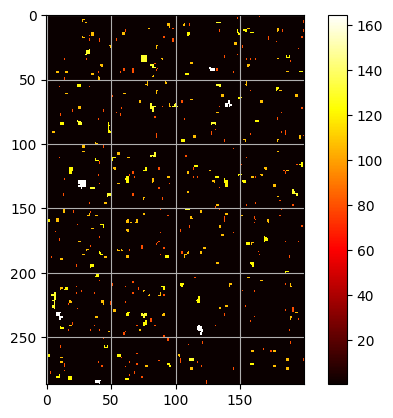

relaxation times 0.8265783660449808 0.5004824451476909
0 0.00043402708280073564


KeyboardInterrupt: 

In [51]:
'''
Example of iterating over every 20 gnp4 samples from 20 to 120 and running the
LBM and storing the results into arrays for conductivity, temperature, and grids
'''
gnp4Conds=[]
gnp4Temps=[]
gnp4Grids=[]
for i in range(20, 121, 20):
    # Load the image
    image_path = f'./data/gnp4_{i}.png'
    length=7923e-6
    width=5085e-6
    resolution=20e-6
    grid=fileToSampleGrid(image_path, length, width, resolution)

    # Run LBM on sample
    cond, T, distF=lbm(grid=grid, ks=[0.305, 2200], rhos=[914, 700], cps=[2140, 2229], dt=1e-6, mapping=gammaMapping[0.0006][4], length=length, width=width, tolerance=2e-9)
    gnp4Conds.append(cond)
    gnp4Grids.append(grid)
    gnp4Temps.append(T)

1.4119220382227138


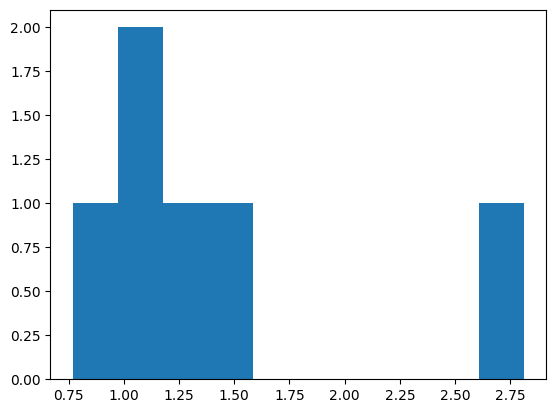

In [ ]:
'''
Displays histogram for conductivity of cross-sections and average of them
'''
plt.hist([sum(conds)/len(conds) for conds in gnp4Conds])
print(sum([sum(conds)/len(conds) for conds in gnp4Conds])/len(gnp4Conds))

In [20]:
'''
Code that could be useful if you need something specific but otherwise would be confusing if left above
'''

'\nCode that could be useful if you need something specific but otherwise would be confusing if left above\n'

In [ ]:
'''
iterates over all combinations of gammaMapping and stores result into arrays
for example if you are looking for the conductivities of each column for gamma 0.01 and 4wt% you would do conds[1][4]
0.1 gamma is stored in conds[1] and 0.0006 gamma is stored in conds[0]
sample applies for grids and temps
'''
conds=[[[] for i in range(5)], [[] for i in range(5)]]
grids=[[[] for i in range(5)], [[] for i in range(5)]]
temps=[[[] for i in range(5)], [[] for i in range(5)]]
for [gamma, wtMap] in gammaMapping.items():
    for [wt, mapping] in wtMap.items():
        grid=generateMicroCTSample(rows=160, cols=160, coreProbs=[0.0005, 0.005], growthProbs=[0.1, 0.1], wts=[wt, 0], densities=[2260, 2200], absorptionRates=[1, 1], nonGrowthDensity=914)
        cond, T, distF=lbm(grid=grid, ks=[0.305, 2200], rhos=[914, 700], cps=[2140, 2229], dt=1e-7)
        conds[gamma==0.01][wt-1].extend(cond)
        grids[gamma==0.01][wt-1].append(grid)
        temps[gamma==0.01][wt-1].append(T)

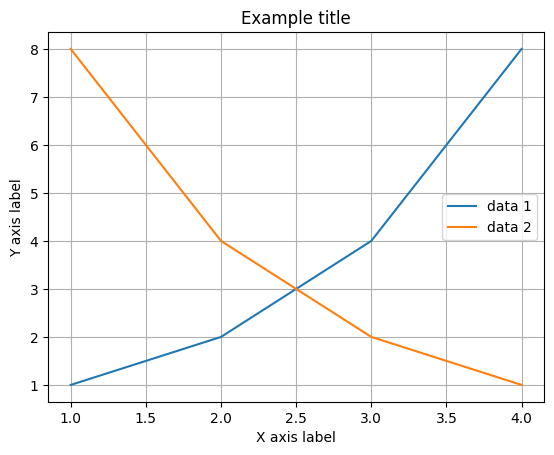

In [ ]:
'''
This is an example usage of the plotting library for basic line plots. The library is called matplotlib and chatGPT should be great at using it.
But how this one works is you first put in the x-axis data and then you put in the y-axis data. The x and y data should have the same dimensions.
In python a range() object creates a list between the first number(inclusive) and the second number(exclusive) so in this case the object is [1,2,3,4]
which corresponds with the x coordinates of the data.
'''
exampleData1=[1, 2, 4, 8]
exampleData2=[8, 4, 2, 1]

plt.plot(range(1,5), exampleData1, label='data 1')
plt.plot(range(1,5), exampleData2, label='data 2')

plt.xlabel('X axis label')
plt.ylabel('Y axis label')
plt.title('Example title')
plt.legend()
plt.grid()
plt.pause(0.1)

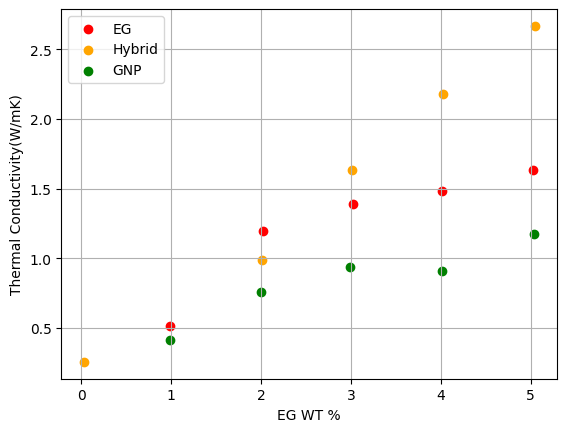

In [55]:
'''
Hard-coded values and graph for your experimental data
'''
experimentEG=[0.9808358718952985, 0.5177376980481276, 2.0206308527956423, 1.195872217655497, 3.017552342730042, 1.3927034476089164, 4.012604161629838, 1.4813274664345695, 5.026094805215738, 1.6370984639685382]
hybrid=[0.026014215947004038, 0.25743436004061665, 2.0083812839482293, 0.9869284206115113, 3.0130393436809957, 1.6315136276453428, 4.024595844817305, 2.1753461309092086, 5.043888915751978, 2.666932611253486]
gnp=[0.9877343132988412, 0.41698499427816166, 1.9957448866108987, 0.7555969247135054, 2.9838337926921654, 0.9412423641667874, 4.011379204745097, 0.9104330867301706, 5.035443160388763, 1.1781345196073696]
plt.scatter(experimentEG[::2], experimentEG[1::2], label='EG', color='red')
plt.scatter(hybrid[::2], hybrid[1::2], label='Hybrid', color='orange')
plt.scatter(gnp[::2], gnp[1::2], label='GNP', color='green')
plt.plot()
plt.xlabel('EG WT %')
plt.ylabel('Thermal Conductivity(W/mK)')
plt.legend()
plt.grid()

In [ ]:
'''
Compiles all widths and heights of every worm in microCT image and prints out histograms
'''
height=6344e-6
width=4071e-6
warped_rgb=fileToSampleGrid('./data/gnp2_20.PNG', height, width, 20e-6)

heights=[]
widths=[]
r=warped_rgb.shape[0]
c=warped_rgb.shape[1]
visited=set()
dirs=[[1,0], [-1,0], [0,1], [0,-1]]
def fill(i, j):
    [r,c]=warped_rgb.shape
    if i<0 or i>=r or j<0 or j>=c or warped_rgb[i,j]==1 or str(i)+','+str(j) in visited:
        return None
    visited.add(str(i)+','+str(j))
    leftmost, rightmost, bottom, top=j, j, i, i
    for [x, y] in dirs:
        x, y=x+i, y+j
        newBoundaries=fill(x, y)
        if newBoundaries is None:
            continue
        [l,r,b,t]=newBoundaries
        leftmost=min(leftmost, l)
        rightmost=max(rightmost, r)
        bottom=max(bottom, b)
        t=min(top, t)
    return [leftmost, rightmost, bottom, top]
for i in range(r):
    for j in range(c):
        dimensions=fill(i, j)
        if dimensions is not None:
            heights.append(dimensions[1]-dimensions[0]+1)
            widths.append(dimensions[2]-dimensions[3]+1)

heightRes=height/287
widthRes=width/200
plt.hist([w*widthRes for w in widths[1:]])
plt.xlabel('Width in m')
plt.ylabel('Number of worms')
plt.pause(0.1)
plt.hist([h*heightRes for h in heights[1:]])
plt.xlabel('Height in m')
plt.ylabel('Number of worms')
plt.pause(0.1)
plt.hist([h*heightRes*w*widthRes for w, h in zip(widths[1:], heights[1:])])
plt.xlabel('Area in m^2')
plt.ylabel('Number of worms')

In [ ]:
'''
Outdated LBM D2Q9 Code
'''
def lbmQ9(grid, paraffinRelaxationTime=0.59567, saturatedEGRelaxationTime=1.2764):
    if type(grid) is list:
        grid=np.array(grid)
    rows, cols=grid.shape

    plt.imshow(grid, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()
    plt.pause(0.01)

    tHot=293
    tCold=283
    parRelaxTime=paraffinRelaxationTime
    satEGRelaxTime=saturatedEGRelaxationTime
    dirs=[[1,0],[0,1],[-1,0],[0,-1],[1,1],[1,-1],[-1,1],[-1,-1]]
    T=np.full((rows, cols), (tHot+tCold)/2)
    tauMap=np.where(grid==1, parRelaxTime, satEGRelaxTime)
    heatCapMap=np.where(grid==1, 2140*914, 700*2229)
    T[:,0]=tHot
    T[:,-1]=tCold
    # omega=0.25/(1+1/np.sqrt(2))
    omegas=np.array([1/6, 1/6, 1/6, 1/6, 1/12, 1/12, 1/12, 1/12])
    # omegas=np.array([omega, omega, omega, omega, omega/np.sqrt(2), omega/np.sqrt(2), omega/np.sqrt(2), omega/np.sqrt(2)])
    distF=np.zeros((8, rows, cols))
    distF[:,:,:]=T[:,:]
    distF*=omegas[:,None,None]
    tolerance=1e-8
    for i in range(10000000):
        T_old=T.copy()

        T=np.sum(distF, axis=0)

        # collision
        for dir in range(8):
            distF[dir]-=(distF[dir]-T*omegas[dir])/tauMap
        
        # streaming step
        for dir, [x,y] in enumerate(dirs):
            distF[dir]=shift(distF[dir], x, y)

        # top/bottom neumann boundary conditions
        for [dir1, dir2] in [[0,2],[4,7],[5,6]]:
            distF[dir1,0,:]=distF[dir2,0,:]
            distF[dir2,-1,:]=distF[dir1,-1,:]

        # reset left/right boundary conditions
        for [dir1, dir2] in [[1,3],[4,7],[6,5]]:
            distF[dir1,:,0]=tHot*omegas[dir1]+(tHot*omegas[dir2]-distF[dir2,:,0])
            distF[dir2,:,-1]=tCold*omegas[dir2]+(tCold*omegas[dir1]-distF[dir1,:,-1])

        # update temp
        T=np.sum(distF, axis=0)

        # verify how much temp changed 
        error=np.sqrt(np.sum(np.square((T-T_old)))/np.sum(np.square(T)))
        if i%10000==0:
            print(i, error)
            print('temps')
            plt.imshow(T, cmap='hot', interpolation='nearest')
            plt.colorbar()
            plt.pause(0.01)
        if error<tolerance:
            print("CONVERGED ON STEP", i, "WITH ERROR", error)
            break
    # Calculate thermal conductivity
    deltaT=tHot-tCold
    velocity=2.4e7
    qFlux=np.sum(velocity*(distF[1]+distF[4]+distF[6]+distF[0]-distF[3]-distF[5]-distF[7]-distF[2])*heatCapMap*(tauMap-0.5)/tauMap)
    cond=1e-3*qFlux/(deltaT*rows*cols)
    # deltaT=tHot-tCold
    # qFlux=(velocity*(np.sum(distF[1])+np.sum(distF[0])-np.sum(distF[2])-np.sum(distF[3]))+velocity*(-np.sum(distF[5])-np.sum(distF[7])+np.sum(distF[4])+np.sum(distF[6])))*(np.mean(tauMap)-0.5)/np.mean(tauMap)
    # cond=2e-4*qFlux/(deltaT*rows*cols)
    return cond, T
# condQ9, TQ9=lbmQ9(grid, 0.59567, 113.69)
# condQ9, TQ9=lbmQ9(grid, 1, 0.505)
condQ9, TQ9=lbmQ9(grid, 0.50305, 1.7)

In [ ]:
'''
Old D2Q9 LBM based on material properties
'''
def lbmQ9Material(grid, lambdas, rhos, cps, deltaT, length=1e-3, width=1e-3, tHot=293, tCold=283):
    if type(grid) is list:
        grid=np.array(grid)
    rows, cols=grid.shape
    grid[:,:]=1

    plt.imshow(grid, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()
    plt.pause(0.01)

    deltaX=width/cols
    thermalDiffusivities=[tc/(rho*cp) for tc, rho, cp in zip(lambdas, rhos, cps)]
    lbThermalDiffusivities=[td*deltaT/(deltaX)**2 for td in thermalDiffusivities]
    
    dirs=[[1,0],[0,1],[-1,0],[0,-1],[1,1],[1,-1],[-1,1],[-1,-1]]
    T=np.full((rows, cols), (tHot+tCold)/2)
    for i, temp in enumerate(np.linspace(tHot, tCold, cols)):
        T[:,i]=temp
    tauMap=np.where(grid==1, 3*lbThermalDiffusivities[0]+0.5, 3*lbThermalDiffusivities[1]+0.5)
    print('relaxation times', 3*lbThermalDiffusivities[0]+0.5, 3*lbThermalDiffusivities[1]+0.5)
    kMap=np.where(grid==1, lambdas[0], lambdas[1])
    T[:,0]=tHot
    T[:,-1]=tCold
    omegas=np.array([1/6, 1/6, 1/6, 1/6, 1/12, 1/12, 1/12, 1/12])
    distF=np.zeros((8, rows, cols))
    distF[:,:,:]=T[:,:]
    distF*=omegas[:,None,None]
    tolerance=1e-9
    for i in range(100000000):
        T_old=T.copy()

        T=np.sum(distF, axis=0)

        # collision
        for dir in range(8):
            distF[dir,:,1:-1]-=(distF[dir,:,1:-1]-T[:,1:-1]*omegas[dir])/tauMap[:,1:-1]
        
        # streaming step
        for dir, [x,y] in enumerate(dirs):
            distF[dir]=shift(distF[dir], x, y)

        # top/bottom neumann boundary conditions
        for [dir1, dir2] in [[0,2],[4,7],[5,6]]:
            distF[dir1,0,:]=distF[dir2,0,:]
            distF[dir2,-1,:]=distF[dir1,-1,:]

        # reset left/right boundary conditions
        for [dir1, dir2] in [[1,3],[4,7],[6,5]]:
            distF[dir1,:,0]=tHot*omegas[dir1]+(tHot*omegas[dir2]-distF[dir2,:,0])
            distF[dir2,:,-1]=tCold*omegas[dir2]+(tCold*omegas[dir1]-distF[dir1,:,-1])

        distF[0,:,0]=tHot*omegas[0]
        distF[2,:,0]=tHot*omegas[2]
        distF[0,:,-1]=tCold*omegas[0]
        distF[2,:,-1]=tCold*omegas[2]

        # update temp
        T=np.sum(distF, axis=0)

        # verify how much temp changed
        error=np.sqrt(np.sum(np.square((T-T_old)))/np.sum(np.square(T)))
        if i%10000==0:
            print('iteration, error: ', i, error)
            print('energy:', np.sum(T))
            print('num of tHot left boundary:', np.sum(np.abs(T[:,0]-tHot)<1e-10))
            print('num of tCold right boundary', np.sum(np.abs(T[:,-1]-tCold)<1e-10))
            print('num of unequal opposite velos on top boundary:', np.sum(distF[0,0,:]!=distF[2,0,:])+np.sum(distF[4,0,:]!=distF[7,0,:])+np.sum(distF[5,0,:]!=distF[6,0,:]))
            print('num of unequal opposite velos on bottom boundary:', np.sum(distF[0,-1,:]!=distF[2,-1,:])+np.sum(distF[4,-1,:]!=distF[7,-1,:])+np.sum(distF[5,-1,:]!=distF[6,-1,:]))
            print('temps')
            plt.imshow(T, cmap='hot', interpolation='nearest')
            plt.colorbar()
            plt.pause(0.01)
        if error<tolerance and i>100000:
            print("CONVERGED ON STEP", i, "WITH ERROR", error)
            break
    # Calculate thermal conductivity
    deltaT=tHot-tCold
    Q=np.sum((distF[1]+distF[4]+distF[6]-distF[3]-distF[5]-distF[7])*kMap*deltaX*(tauMap-0.5)/tauMap)
    cond=Q*width/(width*length*(tHot-tCold))
    return cond, T
condQ9, TQ9=lbmQ9Material(grid=grid, lambdas=[0.305, 120], rhos=[914, 700], cps=[2140, 2229], deltaT=2e-7)
# condQ9, TQ9=lbmQ9Material(grid=grid, lambdas=[0.305, 120], rhos=[914, 700], cps=[2140, 2229], speed=250)